In [0]:
%matplotlib inline
import numpy as np
import pylab as plt
from scipy.io import loadmat
from mpl_toolkits import mplot3d
from google.colab import files

In [22]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
# %% define basic parameters
# array parameters
array_number = 2

# frequency parameters
lambda_center = 3e8/12.5e9
frequency_step = 500e6
frequency_conversion = frequency_step/5e6
frequency = np.arange(12e9, 13e9+frequency_step,frequency_step)
lambda_frequency = np.divide(3e8, frequency) 
frequency_points = np.shape(frequency)[0]
center_freq_new = np.int((frequency_points-1)/2)

In [0]:
# %% load phase shifter measuremnt data
phase = loadmat('/content/gdrive/My Drive/Projects/Phase Shifter/PhasW.mat')
amplitude = loadmat('/content/gdrive/My Drive/Projects/Phase Shifter/AmpW.mat')
#phase = loadmat('PhasW.mat')
#amplitude = loadmat('AmpW.mat')
phase = np.array(phase['PV2'])
amplitude = np.array(amplitude['PV2'])
PS_number = 3
center_freq = 100
maximum_amplitude = amplitude[:, 0, PS_number].max()
amplitude = (1/maximum_amplitude) * amplitude
control_voltage = np.arange(0, 11)

In [0]:
def IL_voltage_for_phase(phi, phase, amplitude, control_voltage, center_freq, PS_number):
    m = np.shape(phi)[0]
    n = np.shape(phase)[1]
    insertion_loss = np.zeros(m)
    voltage_out = -1 * np.ones(m)
    for i in range(m):
        for j in range(n - 1):
            if (phi[i]>=phase[center_freq,j , PS_number] and phi[i]<phase[center_freq,j+1 , PS_number]) or (phi[i]>phase[center_freq,j , PS_number] and phi[i]<=phase[center_freq,j+1 , PS_number]) :
                phase_slope = (phase[center_freq,j+1 , PS_number]-phase[center_freq,j , PS_number])/(control_voltage[j+1]-control_voltage[j])
                amplitude_slope = (amplitude[center_freq,j+1 , PS_number]-amplitude[center_freq,j , PS_number])/(control_voltage[j+1]-control_voltage[j])
                phase_b = phase[center_freq,j , PS_number] - phase_slope * control_voltage[j]
                amplitude_b = amplitude[center_freq,j , PS_number] - amplitude_slope * control_voltage[j]
                insertion_loss[i] = (amplitude_slope/phase_slope) * (phi[i] - phase_b) + amplitude_b
                voltage_out[i] = (1/phase_slope) * (phi[i] - phase_b)
    return insertion_loss, voltage_out

In [0]:
def IL_voltage_for_phase_single_theta(phi, phase, amplitude, control_voltage, center_freq, PS_number):
  n = np.shape(phase)[1]
  insertion_loss = 0
  voltage_out = -1
  for j in range(n - 1):
    if (phi>=phase[center_freq,j , PS_number] and phi<phase[center_freq,j+1 , PS_number]) or (phi>phase[center_freq,j , PS_number] and phi<=phase[center_freq,j+1 , PS_number]) :
      phase_slope = (phase[center_freq,j+1 , PS_number]-phase[center_freq,j , PS_number])/(control_voltage[j+1]-control_voltage[j])
      amplitude_slope = (amplitude[center_freq,j+1 , PS_number]-amplitude[center_freq,j , PS_number])/(control_voltage[j+1]-control_voltage[j])
      phase_b = phase[center_freq,j , PS_number] - phase_slope * control_voltage[j]
      amplitude_b = amplitude[center_freq,j , PS_number] - amplitude_slope * control_voltage[j]
      insertion_loss = (amplitude_slope/phase_slope) * (phi - phase_b) + amplitude_b
      voltage_out = (1/phase_slope) * (phi - phase_b)
  return insertion_loss, voltage_out

In [0]:
def IL_phase_for_voltage(voltage, phase, amplitude, control_voltage, center_freq, PS_number):
    m = np.shape(voltage)[0]
    n = np.shape(phase)[1]
    insertion_loss = np.zeros(m)
    phase_out = -1 * np.ones(m)
    for i in range(m):
        for j in range(n - 1):
            if (voltage[i]>=control_voltage[j] and voltage[i]<control_voltage[j+1]) or (voltage[i]>control_voltage[j] and voltage[i]<=control_voltage[j+1]) :
                phase_slope = (phase[center_freq,j+1 , PS_number]-phase[center_freq,j , PS_number])/(control_voltage[j+1]-control_voltage[j])
                amplitude_slope = (amplitude[center_freq,j+1 , PS_number]-amplitude[center_freq,j , PS_number])/(control_voltage[j+1]-control_voltage[j])
                phase_b = phase[center_freq,j , PS_number] - phase_slope * control_voltage[j]
                amplitude_b = amplitude[center_freq,j , PS_number] - amplitude_slope * control_voltage[j]
                phase_out[i] = phase_slope * voltage[i] + phase_b
                insertion_loss[i] = amplitude_slope * voltage[i] + amplitude_b
    return insertion_loss, phase_out

In [0]:
def IL_phase_for_voltage_single_theta(voltage, phase, amplitude, control_voltage, center_freq, PS_number):
  n = np.shape(phase)[1]
  insertion_loss = 0
  phase_out = -1
  for j in range(n - 1):
    if (voltage>=control_voltage[j] and voltage<control_voltage[j+1]) or (voltage>control_voltage[j] and voltage<=control_voltage[j+1]) :
      phase_slope = (phase[center_freq,j+1 , PS_number]-phase[center_freq,j , PS_number])/(control_voltage[j+1]-control_voltage[j])
      amplitude_slope = (amplitude[center_freq,j+1 , PS_number]-amplitude[center_freq,j , PS_number])/(control_voltage[j+1]-control_voltage[j])
      phase_b = phase[center_freq,j , PS_number] - phase_slope * control_voltage[j]
      amplitude_b = amplitude[center_freq,j , PS_number] - amplitude_slope * control_voltage[j]
      phase_out = phase_slope * voltage + phase_b
      insertion_loss = amplitude_slope * voltage + amplitude_b
  return insertion_loss, phase_out

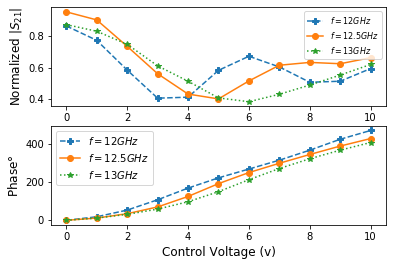

In [29]:
# %% plot phase shifter measuremnt data
fig, (ax1, ax2) = plt.subplots(2, 1)
ax1.plot(control_voltage,amplitude[0, :, PS_number], 'P-', label='$f = 12 GHz$', linestyle='--')
ax1.plot(control_voltage,amplitude[center_freq, :, PS_number], 'o-', label='$f = 12.5 GHz$')
ax1.plot(control_voltage,amplitude[200, :, PS_number], '*-', label='$f = 13 GHz$', linestyle=':')
ax1.set_ylabel(r'Normalized $|S_{21}|$', fontsize=12)
ax1.legend(loc ='best', fontsize=8)

ax2.plot(control_voltage,phase[0, :, PS_number], 'P-', label='$f = 12 GHz$', linestyle='--')
ax2.plot(control_voltage,phase[center_freq, :, PS_number], 'o-', label='$f = 12.5 GHz$')
ax2.plot(control_voltage,phase[200, :, PS_number], '*-', label='$f = 13 GHz$', linestyle=':')
ax2.set_xlabel('Control Voltage (v)', fontsize=12)
ax2.set_ylabel(r'Phase$\degree$', fontsize=12)
ax2.legend(loc ='best')

#plt.savefig('RTPS.eps')
#files.download("RTPS.eps") 

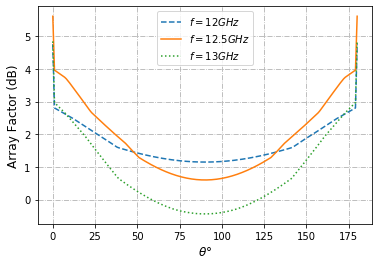

In [30]:
# %% array gain coherent for different frequencies

# phase parameters
theta = np.arange(0,181,1)
phi_1 = np.zeros((181, frequency_points))
phi_2 = np.zeros((181, frequency_points))
phi = np.zeros((181, array_number, frequency_points))
for f in range(frequency_points): 
    phi_1[:, f] = (np.pi/(2*lambda_frequency[f]))*lambda_center*np.sin(np.pi*theta/180) * (180/np.pi)
    phi_2[:, f] = (2*np.pi - (np.pi/(2*lambda_frequency[f]))*lambda_center*np.sin(np.pi*theta/180)) * (180/np.pi)
phi_2[0, :] = 0
phi_2[180, :] = 0
phi[:, 0, :] = phi_1
phi[:, 1, :] = phi_2

array_gain_coherent = np.zeros((181, frequency_points))
for f in range(frequency_points):
  array_gain_coherent[:, f] = np.abs(IL_voltage_for_phase(phi[:, 0, f], phase, amplitude, control_voltage, np.int(f*frequency_conversion), PS_number)[0] + IL_voltage_for_phase(phi[:, 1, f], phase, amplitude, control_voltage, np.int(f*frequency_conversion), PS_number)[0])

fig, ax = plt.subplots()
ax.plot(theta, 20*np.log10(array_gain_coherent[:, 0]), label='$f = 12 GHz$', linestyle='--')
ax.plot(theta, 20*np.log10(array_gain_coherent[:, 1]), label='$f = 12.5 GHz$' )
ax.plot(theta, 20*np.log10(array_gain_coherent[:, 2]), label='$f = 13 GHz$', linestyle=':' )
ax.set_xlabel(r'$\theta\degree$', fontsize=12)
ax.set_ylabel('Array Factor (dB)', fontsize=12)
ax.legend(loc ='best')
ax.grid(True, linestyle='-.')

#plt.savefig('coherent-frequencies.eps')
#files.download("coherent-frequencies.eps") 

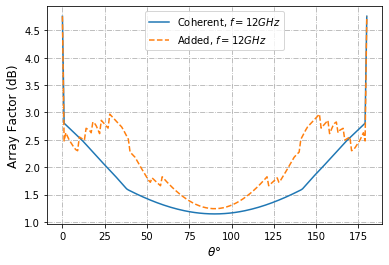

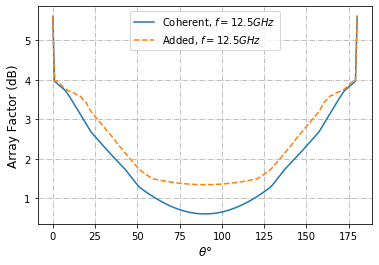

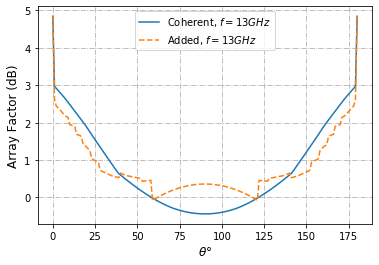

In [31]:
# %% comparison array factors between coherent and best added mode
array_number = 2

# phase parameters for initial voltage calculation
theta = np.arange(0,181,1)
phi_1 = np.zeros((181, frequency_points))
phi_2 = np.zeros((181, frequency_points))
phi = np.zeros((181, array_number, frequency_points))
for f in range(frequency_points): 
    phi_1[:, f] = (np.pi/(2*lambda_frequency[f]))*lambda_center*np.sin(np.pi*theta/180) * (180/np.pi)
    phi_2[:, f] = (2*np.pi - (np.pi/(2*lambda_frequency[f]))*lambda_center*np.sin(np.pi*theta/180)) * (180/np.pi)
phi_2[0, :] = 0
phi_2[180, :] = 0
phi[:, 0, :] = phi_1
phi[:, 1, :] = phi_2

array_gain_coherent = np.zeros((181, frequency_points))
for f in range(frequency_points):
  array_gain_coherent[:, f] = np.abs(IL_voltage_for_phase(phi[:, 0, f], phase, amplitude, control_voltage, np.int(f*frequency_conversion), PS_number)[0] + IL_voltage_for_phase(phi[:, 1, f], phase, amplitude, control_voltage, np.int(f*frequency_conversion), PS_number)[0])

# adding constant voltage to both elements for each theta
voltage = np.zeros((181, array_number))
voltage_delta = np.arange(-2, 2.1, 0.2)
voltage_delta[20] = 0
voltage_delta_final = np.zeros((181))
array_gain_added = np.zeros((181, frequency_points))
array_gain = np.zeros((np.shape(voltage_delta)[0]))
for k in range(array_number):
  voltage[:, k] = IL_voltage_for_phase(phi[:, k, center_freq_new], phase, amplitude, control_voltage, np.int(center_freq_new*frequency_conversion), PS_number)[1]
voltage_added = voltage

# phase parameters
theta = np.arange(0,181,1)
phi_1 = np.zeros((181, frequency_points))
phi_2 = np.zeros((181, frequency_points))
phi = np.zeros((181, array_number, frequency_points))
for f in range(frequency_points): 
    phi_1[:, f] = (np.pi/(2*lambda_frequency[f]))*lambda_center*np.sin(np.pi*theta/180) * (180/np.pi)
    phi_2[:, f] =  -1 * (np.pi/(2*lambda_frequency[f]))*lambda_center*np.sin(np.pi*theta/180) * (180/np.pi)
phi[:, 0, :] = phi_1
phi[:, 1, :] = phi_2

for t in theta:
  for i in range(np.shape(voltage_delta)[0]):
    IL_state_1 = IL_phase_for_voltage_single_theta(voltage[t, 0]+voltage_delta[i], phase, amplitude, control_voltage, center_freq, PS_number)[0]
    phase_state_1 = IL_phase_for_voltage_single_theta(voltage[t, 0]+voltage_delta[i], phase, amplitude, control_voltage, center_freq, PS_number)[1]
    IL_state_2 = IL_phase_for_voltage_single_theta(voltage[t, 1]+voltage_delta[i], phase, amplitude, control_voltage, center_freq, PS_number)[0]
    phase_state_2 = IL_phase_for_voltage_single_theta(voltage[t, 1]+voltage_delta[i], phase, amplitude, control_voltage, center_freq, PS_number)[1]
    array_gain[i] = np.abs(IL_state_1 * np.exp(1j*(np.pi/180)*(phase_state_1 - phi[t, 0, center_freq_new])) + IL_state_2 * np.exp(1j*(np.pi/180)*(phase_state_2 - phi[t, 1, center_freq_new])))
  state_max = np.argmax(array_gain)
  voltage_delta_final[t] = voltage_delta[state_max]
voltage_added[:, 0] = voltage[:, 0] + voltage_delta_final
voltage_added[:, 1] = voltage[:, 1] + voltage_delta_final
for f in range(frequency_points):
  IL_added_1 = IL_phase_for_voltage(voltage_added[:, 0], phase, amplitude, control_voltage, np.int(f*frequency_conversion), PS_number)[0]
  phase_added_1 = IL_phase_for_voltage(voltage_added[:, 0], phase, amplitude, control_voltage, np.int(f*frequency_conversion), PS_number)[1]
  IL_added_2 = IL_phase_for_voltage(voltage_added[:, 1], phase, amplitude, control_voltage, np.int(f*frequency_conversion), PS_number)[0]
  phase_added_2 = IL_phase_for_voltage(voltage_added[:, 1], phase, amplitude, control_voltage, np.int(f*frequency_conversion), PS_number)[1]
  array_gain_added[:, f] = np.abs(IL_added_1 * np.exp(1j*(np.pi/180)*(phase_added_1 - phi[:, 0, f])) + IL_added_2 * np.exp(1j*(np.pi/180)*(phase_added_2 - phi[:, 1, f])))

fig, ax = plt.subplots()
ax.plot(theta, 20*np.log10(array_gain_coherent[:, 0]), label='Coherent, $f = 12 GHz$')
ax.plot(theta, 20*np.log10(np.abs(array_gain_added[:, 0])), label='Added, $f = 12 GHz$', linestyle='--')
ax.set_xlabel(r'$\theta\degree$', fontsize=12)
ax.set_ylabel('Array Factor (dB)', fontsize=12)
ax.legend(loc ='best')
ax.grid(True, linestyle='-.')

fig, ax = plt.subplots()
ax.plot(theta, 20*np.log10(array_gain_coherent[:, 1]), label='Coherent, $f = 12.5 GHz$')
ax.plot(theta, 20*np.log10(np.abs(array_gain_added[:, 1])), label='Added, $f = 12.5 GHz$', linestyle='--')
ax.set_xlabel(r'$\theta\degree$', fontsize=12)
ax.set_ylabel('Array Factor (dB)', fontsize=12)
ax.legend(loc ='best')
ax.grid(True, linestyle='-.')

fig, ax = plt.subplots()
ax.plot(theta, 20*np.log10(array_gain_coherent[:, 2]), label='Coherent, $f = 13 GHz$')
ax.plot(theta, 20*np.log10(np.abs(array_gain_added[:, 2])), label='Added, $f = 13 GHz$', linestyle='--')
ax.set_xlabel(r'$\theta\degree$', fontsize=12)
ax.set_ylabel('Array Factor (dB)', fontsize=12)
ax.legend(loc ='best')
ax.grid(True, linestyle='-.')

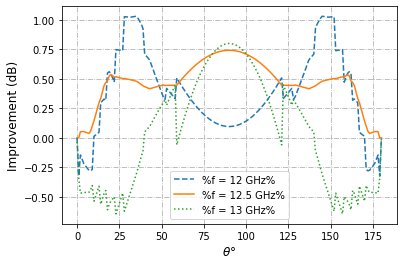

In [32]:
# %% plot improvement from coherent to added mode 
improvement = 20*np.log10(array_gain_added) - 20*np.log10(array_gain_coherent)
fig, ax = plt.subplots()
ax.plot(theta, improvement[:, 0], label='%f = 12 GHz%', linestyle='--')
ax.plot(theta, improvement[:, 1], label='%f = 12.5 GHz%')
ax.plot(theta, improvement[:, 2], label='%f = 13 GHz%', linestyle=':')
ax.set_xlabel(r'$\theta\degree$', fontsize=12)
ax.set_ylabel('Improvement (dB)', fontsize=12)
ax.legend(loc ='best')
ax.grid(True, linestyle='-.')

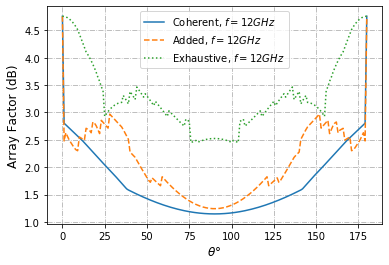

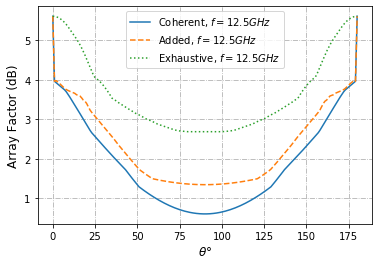

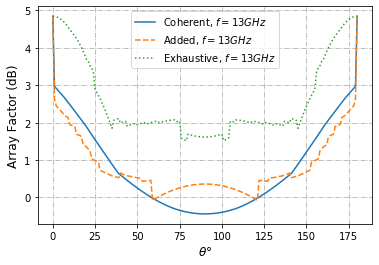

In [33]:
# %% non-coherent mode optimization for 1*2 array with exhaustive search

# phase parameters
theta = np.arange(0,181,1)
phi_1 = (np.pi/2)*np.sin(np.pi*theta/180) * (180/np.pi)
phi_2 = -1 * (np.pi/2)*np.sin(np.pi*theta/180) * (180/np.pi)
phi = np.zeros((181, array_number))
phi[:, 0] = phi_1
phi[:, 1] = phi_2

# voltage cartesian products
voltage_step = 0.2
voltage_1 = np.arange(0, 10, voltage_step)
voltage_2 = np.arange(0, 10, voltage_step)
voltage = np.transpose([np.tile(voltage_1, len(voltage_2)), np.repeat(voltage_2, len(voltage_1))])
states = np.shape(voltage)[0]
array_gain_state = np.zeros((states))
voltage_exhaustive = np.zeros((181, 2))

for t in theta:
  for i in range(0, states, 1):
    IL_state_1 = IL_phase_for_voltage_single_theta(voltage[i, 0], phase, amplitude, control_voltage, center_freq, PS_number)[0]
    phase_state_1 = IL_phase_for_voltage_single_theta(voltage[i, 0], phase, amplitude, control_voltage, center_freq, PS_number)[1]
    IL_state_2 = IL_phase_for_voltage_single_theta(voltage[i, 1], phase, amplitude, control_voltage, center_freq, PS_number)[0]
    phase_state_2 = IL_phase_for_voltage_single_theta(voltage[i, 1], phase, amplitude, control_voltage, center_freq, PS_number)[1]
    array_gain_state[i] = np.abs(IL_state_1 * np.exp(1j*(np.pi/180)*(phase_state_1 - phi[t, 0])) + IL_state_2 * np.exp(1j*(np.pi/180)*(phase_state_2 - phi[t, 1])))
  state_max = np.argmax(array_gain_state)
  voltage_exhaustive[t, :] = voltage[state_max, :]

# phase parameters
theta = np.arange(0,181,1)
phi_1 = np.zeros((181, frequency_points))
phi_2 = np.zeros((181, frequency_points))
for f in range(frequency_points): 
    phi_1[:, f] = (np.pi/(2*lambda_frequency[f]))*lambda_center*np.sin(np.pi*theta/180) * (180/np.pi)
    phi_2[:, f] = - (np.pi/(2*lambda_frequency[f]))*lambda_center*np.sin(np.pi*theta/180) * (180/np.pi)
phi = np.zeros((181, array_number, frequency_points))
phi[:, 0, :] = phi_1
phi[:, 1, :] = phi_2

array_gain_exhaustive = np.zeros((181, frequency_points))
for f in range(frequency_points):
  IL_final_0 = IL_phase_for_voltage(voltage_exhaustive[:, 0], phase, amplitude, control_voltage, np.int(f*frequency_conversion), PS_number)[0]
  phase_final_0 = IL_phase_for_voltage(voltage_exhaustive[:, 0], phase, amplitude, control_voltage, np.int(f*frequency_conversion), PS_number)[1]
  IL_final_1 = IL_phase_for_voltage(voltage_exhaustive[:, 1], phase, amplitude, control_voltage, np.int(f*frequency_conversion), PS_number)[0]
  phase_final_1 = IL_phase_for_voltage(voltage_exhaustive[:, 1], phase, amplitude, control_voltage, np.int(f*frequency_conversion), PS_number)[1]
  array_gain_exhaustive[:, f] = np.abs(IL_final_0 * np.exp(1j*(np.pi/180)*(phase_final_0 - phi[:, 0, f])) + IL_final_1 * np.exp(1j*(np.pi/180)*(phase_final_1 - phi[:, 1, f])))

fig, ax = plt.subplots()
ax.plot(theta, 20*np.log10(array_gain_coherent[:, 0]), label='Coherent, $f = 12 GHz$')
ax.plot(theta, 20*np.log10(np.abs(array_gain_added[:, 0])), label='Added, $f = 12 GHz$', linestyle='--')
ax.plot(theta, 20*np.log10(np.abs(array_gain_exhaustive[:, 0])), label='Exhaustive, $f = 12 GHz$', linestyle=':')
ax.set_xlabel(r'$\theta\degree$', fontsize=12)
ax.set_ylabel('Array Factor (dB)', fontsize=12)
ax.legend(loc ='best')
ax.grid(True, linestyle='-.')

fig, ax = plt.subplots()
ax.plot(theta, 20*np.log10(array_gain_coherent[:, 1]), label='Coherent, $f = 12.5 GHz$')
ax.plot(theta, 20*np.log10(np.abs(array_gain_added[:, 1])), label='Added, $f = 12.5 GHz$', linestyle='--')
ax.plot(theta, 20*np.log10(np.abs(array_gain_exhaustive[:, 1])), label='Exhaustive, $f = 12.5 GHz$', linestyle=':')
ax.set_xlabel(r'$\theta\degree$', fontsize=12)
ax.set_ylabel('Array Factor (dB)', fontsize=12)
ax.legend(loc ='best')
ax.grid(True, linestyle='-.')

fig, ax = plt.subplots()
ax.plot(theta, 20*np.log10(array_gain_coherent[:, 2]), label='Coherent, $f = 13 GHz$')
ax.plot(theta, 20*np.log10(np.abs(array_gain_added[:, 2])), label='Added, $f = 13 GHz$', linestyle='--')
ax.plot(theta, 20*np.log10(np.abs(array_gain_exhaustive[:, 2])), label='Exhaustive, $f = 13 GHz$', linestyle=':')
ax.set_xlabel(r'$\theta\degree$', fontsize=12)
ax.set_ylabel('Array Factor (dB)', fontsize=12)
ax.legend(loc ='best')
ax.grid(True, linestyle='-.')

In [0]:
# %% wideband mode optimization for 1*2 array with exhaustive search

# phase parameters
theta = np.arange(0,181,1)
phi_1 = np.zeros((181, frequency_points))
phi_2 = np.zeros((181, frequency_points))
phi = np.zeros((181, array_number, frequency_points))
for f in range(frequency_points): 
    phi_1[:, f] = (np.pi/(2*lambda_frequency[f]))*lambda_center*np.sin(np.pi*theta/180) * (180/np.pi)
    phi_2[:, f] =  -1 * (np.pi/(2*lambda_frequency[f]))*lambda_center*np.sin(np.pi*theta/180) * (180/np.pi)
phi[:, 0, :] = phi_1
phi[:, 1, :] = phi_2

# voltage cartesian products
voltage_step = 0.2
voltage_1 = np.arange(0, 8.3, voltage_step)
voltage_2 = np.arange(0, 8.3, voltage_step)
voltage = np.transpose([np.tile(voltage_1, len(voltage_2)), np.repeat(voltage_2, len(voltage_1))])
states = np.shape(voltage)[0]
array_gain_state_wideband = np.zeros((states))
array_gain_state = np.zeros((states, frequency_points))
voltage_exhaustive_wideband = np.zeros((181, 2))

for t in theta:
  for i in range(0, states, 1):
    for f in range(frequency_points):
      IL_state_1 = IL_phase_for_voltage_single_theta(voltage[i, 0], phase, amplitude, control_voltage, np.int(f*frequency_conversion), PS_number)[0]
      phase_state_1 = IL_phase_for_voltage_single_theta(voltage[i, 0], phase, amplitude, control_voltage, np.int(f*frequency_conversion), PS_number)[1]
      IL_state_2 = IL_phase_for_voltage_single_theta(voltage[i, 1], phase, amplitude, control_voltage, np.int(f*frequency_conversion), PS_number)[0]
      phase_state_2 = IL_phase_for_voltage_single_theta(voltage[i, 1], phase, amplitude, control_voltage, np.int(f*frequency_conversion), PS_number)[1]
      array_gain_state[i, f] = np.abs(IL_state_1 * np.exp(1j*(np.pi/180)*(phase_state_1 - phi[t, 0, f])) + IL_state_2 * np.exp(1j*(np.pi/180)*(phase_state_2 - phi[t, 1, f])))
    for f in range(frequency_points):
      array_gain_state_wideband[i] = array_gain_state_wideband[i] + np.power(array_gain_state[i, f], 2)
  state_max = np.argmax(array_gain_state_wideband)
  voltage_exhaustive_wideband[t, :] = voltage[state_max, :]

array_gain_exhaustive_wideband = np.zeros((181, 1))
array_gain_exhaustive =  np.zeros((181, frequency_points))
for f in range(frequency_points):
  IL_final_0 = IL_phase_for_voltage(voltage_exhaustive[:, 0], phase, amplitude, control_voltage, np.int(f*frequency_conversion), PS_number)[0]
  phase_final_0 = IL_phase_for_voltage(voltage_exhaustive[:, 0], phase, amplitude, control_voltage, np.int(f*frequency_conversion), PS_number)[1]
  IL_final_1 = IL_phase_for_voltage(voltage_exhaustive[:, 1], phase, amplitude, control_voltage, np.int(f*frequency_conversion), PS_number)[0]
  phase_final_1 = IL_phase_for_voltage(voltage_exhaustive[:, 1], phase, amplitude, control_voltage, np.int(f*frequency_conversion), PS_number)[1]
  array_gain_exhaustive[:, f] = np.abs(IL_final_0 * np.exp(1j*(np.pi/180)*(phase_final_0 - phi[:, 0, f])) + IL_final_1 * np.exp(1j*(np.pi/180)*(phase_final_1 - phi[:, 1, f])))
for f in range(frequency_points):
  array_gain_exhaustive_wideband = array_gain_exhaustive_wideband + np.power(np.reshape(array_gain_exhaustive[:, f], (181, 1)), 2)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


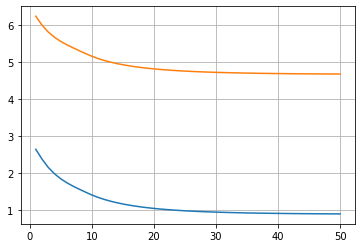

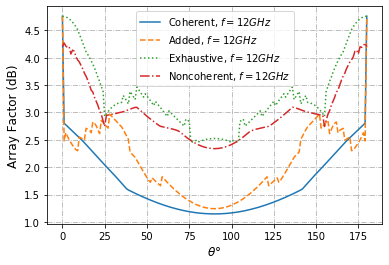

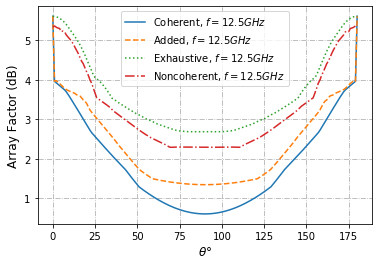

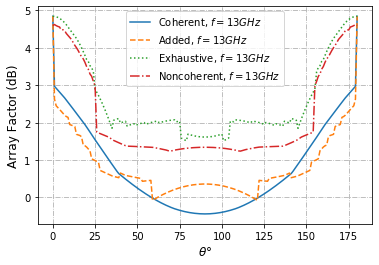

In [39]:
# %% non-coherent mode optimization for 1*2 array with gradient descent
array_number = 2

# phase parameters for initial voltage calculation (second element has a positive phase shifting)
theta = np.arange(0,181,1)
phi_1 = np.zeros((181, frequency_points))
phi_2 = np.zeros((181, frequency_points))
phi = np.zeros((181, array_number, frequency_points))
for f in range(frequency_points): 
    phi_1[:, f] = (np.pi/(2*lambda_frequency[f]))*lambda_center*np.sin(np.pi*theta/180) * (180/np.pi)
    phi_2[:, f] = (2*np.pi - (np.pi/(2*lambda_frequency[f]))*lambda_center*np.sin(np.pi*theta/180)) * (180/np.pi)
phi_2[0, :] = 0
phi_2[180, :] = 0
phi[:, 0, :] = phi_1
phi[:, 1, :] = phi_2

# gradient parameters
gradient = np.zeros((181, array_number))
gradient_rate = 10
gradient_rate_dc = 0.5
gradient_delta = 0.5
steps = 50
voltage_noncoherent = np.zeros((181, array_number))
for k in range(array_number):
  voltage_noncoherent[:, k] = IL_voltage_for_phase(phi[:, k, center_freq_new], phase, amplitude, control_voltage, np.int(center_freq_new*frequency_conversion), PS_number)[1]

IL_plus = np.zeros((181, array_number))
phase_plus = np.zeros((181, array_number))
IL_minus = np.zeros((181, array_number))
phase_minus = np.zeros((181, array_number))
IL_plus[:, 0] = IL_phase_for_voltage(voltage_noncoherent[:, 0], phase, amplitude, control_voltage, center_freq, PS_number)[0]
IL_plus[:, 1] = IL_phase_for_voltage(voltage_noncoherent[:, 1], phase, amplitude, control_voltage, center_freq, PS_number)[0]
phase_plus[:, 0] = IL_phase_for_voltage(voltage_noncoherent[:, 0], phase, amplitude, control_voltage, center_freq, PS_number)[1]
phase_plus[:, 1] = IL_phase_for_voltage(voltage_noncoherent[:, 1], phase, amplitude, control_voltage, center_freq, PS_number)[1]
IL_minus[:, 0] = IL_phase_for_voltage(voltage_noncoherent[:, 0], phase, amplitude, control_voltage, center_freq, PS_number)[0]
IL_minus[:, 1] = IL_phase_for_voltage(voltage_noncoherent[:, 1], phase, amplitude, control_voltage, center_freq, PS_number)[0]
phase_minus[:, 0] = IL_phase_for_voltage(voltage_noncoherent[:, 0], phase, amplitude, control_voltage, center_freq, PS_number)[1]
phase_minus[:, 1] = IL_phase_for_voltage(voltage_noncoherent[:, 1], phase, amplitude, control_voltage, center_freq, PS_number)[1]

step_voltage = np.zeros((steps,array_number))
# phase parameters (second element has a minus phase shifting)
theta = np.arange(0,181,1)
phi_1 = np.zeros((181, frequency_points))
phi_2 = np.zeros((181, frequency_points))
phi = np.zeros((181, array_number, frequency_points))
for f in range(frequency_points): 
    phi_1[:, f] = (np.pi/(2*lambda_frequency[f]))*lambda_center*np.sin(np.pi*theta/180) * (180/np.pi)
    phi_2[:, f] =  -1 * (np.pi/(2*lambda_frequency[f]))*lambda_center*np.sin(np.pi*theta/180) * (180/np.pi)
phi[:, 0, :] = phi_1
phi[:, 1, :] = phi_2

result_phase = 90
for i in range(steps):
  for k in range(array_number):
    IL_plus[:, k] = IL_phase_for_voltage(np.remainder(voltage_noncoherent[:, k]+(gradient_delta), 8), phase, amplitude, control_voltage, center_freq, PS_number)[0]
    phase_plus[:, k] = IL_phase_for_voltage(np.remainder(voltage_noncoherent[:, k]+(gradient_delta), 8), phase, amplitude, control_voltage, center_freq, PS_number)[1]
    IL_minus[:, k] = IL_phase_for_voltage(np.remainder(voltage_noncoherent[:, k]-(gradient_delta), 8), phase, amplitude, control_voltage, center_freq, PS_number)[0]
    phase_minus[:, k] = IL_phase_for_voltage(np.remainder(voltage_noncoherent[:, k]-(gradient_delta), 8), phase, amplitude, control_voltage, center_freq, PS_number)[1]
    
    array_gain_noncoherent_plus = np.zeros((181, 1))
    array_gain_noncoherent_minus = np.zeros((181, 1))
    for n in range(array_number):
      array_gain_noncoherent_plus = np.reshape(array_gain_noncoherent_plus, (181,)) + (IL_plus[:, n] * np.exp(1j*(np.pi/180)*(phase_plus[:, n] - phi[:, n, center_freq_new])))
      array_gain_noncoherent_minus = np.reshape(array_gain_noncoherent_minus, (181,)) + (IL_minus[:, n] * np.exp(1j*(np.pi/180)*(phase_minus[:, n] - phi[:, n, center_freq_new])))
            
    array_gain_noncoherent_plus = np.abs(array_gain_noncoherent_plus)
    array_gain_noncoherent_minus = np.abs(array_gain_noncoherent_minus)
    gradient[:, k] = (1/(2*gradient_delta)) * (array_gain_noncoherent_plus - array_gain_noncoherent_minus)                                         
    voltage_noncoherent[:, k] = np.remainder((voltage_noncoherent[:, k] + (0.5 * (gradient_rate_dc + gradient_rate/(i+1))) * gradient[:, k]), 8.3)

  #step_voltage[i, 0] = gradient[result_phase, 1]
  step_voltage[i, :] = voltage_noncoherent[result_phase, :]

array_gain_noncoherent = np.zeros((181, frequency_points))
for f in range(frequency_points):
  IL_final_0 = IL_phase_for_voltage(voltage_noncoherent[:, 0], phase, amplitude, control_voltage, np.int(f*frequency_conversion), PS_number)[0]
  phase_final_0 = IL_phase_for_voltage(voltage_noncoherent[:, 0], phase, amplitude, control_voltage, np.int(f*frequency_conversion), PS_number)[1]
  IL_final_1 = IL_phase_for_voltage(voltage_noncoherent[:, 1], phase, amplitude, control_voltage, np.int(f*frequency_conversion), PS_number)[0]
  phase_final_1 = IL_phase_for_voltage(voltage_noncoherent[:, 1], phase, amplitude, control_voltage, np.int(f*frequency_conversion), PS_number)[1]
  array_gain_noncoherent[:, f] = np.abs(IL_final_0 * np.exp(1j*(np.pi/180)*(phase_final_0 - phi[:, 0, f])) + IL_final_1 * np.exp(1j*(np.pi/180)*(phase_final_1 - phi[:, 1, f])))
  
fig, ax = plt.subplots()
ax.plot(np.arange(1, steps+1), step_voltage)
ax.grid(True)

fig, ax = plt.subplots()
ax.plot(theta, 20*np.log10(array_gain_coherent[:, 0]), label='Coherent, $f = 12 GHz$')
ax.plot(theta, 20*np.log10(np.abs(array_gain_added[:, 0])), label='Added, $f = 12 GHz$', linestyle='--')
ax.plot(theta, 20*np.log10(np.abs(array_gain_exhaustive[:, 0])), label='Exhaustive, $f = 12 GHz$', linestyle=':')
ax.plot(theta, 20*np.log10(np.abs(array_gain_noncoherent[:, 0])), label='Noncoherent, $f = 12 GHz$', linestyle='-.')
ax.set_xlabel(r'$\theta\degree$', fontsize=12)
ax.set_ylabel('Array Factor (dB)', fontsize=12)
ax.legend(loc ='best')
ax.grid(True, linestyle='-.')

fig, ax = plt.subplots()
ax.plot(theta, 20*np.log10(array_gain_coherent[:, 1]), label='Coherent, $f = 12.5 GHz$')
ax.plot(theta, 20*np.log10(np.abs(array_gain_added[:, 1])), label='Added, $f = 12.5 GHz$', linestyle='--')
ax.plot(theta, 20*np.log10(np.abs(array_gain_exhaustive[:, 1])), label='Exhaustive, $f = 12.5 GHz$', linestyle=':')
ax.plot(theta, 20*np.log10(np.abs(array_gain_noncoherent[:, 1])), label='Noncoherent, $f = 12.5 GHz$', linestyle='-.')
ax.set_xlabel(r'$\theta\degree$', fontsize=12)
ax.set_ylabel('Array Factor (dB)', fontsize=12)
ax.legend(loc ='best')
ax.grid(True, linestyle='-.')

#plt.savefig('singletone-comparison.eps')
#files.download("singletone-comparison.eps")

fig, ax = plt.subplots()
ax.plot(theta, 20*np.log10(array_gain_coherent[:, 2]), label='Coherent, $f = 13 GHz$')
ax.plot(theta, 20*np.log10(np.abs(array_gain_added[:, 2])), label='Added, $f = 13 GHz$', linestyle='--')
ax.plot(theta, 20*np.log10(np.abs(array_gain_exhaustive[:, 2])), label='Exhaustive, $f = 13 GHz$', linestyle=':')
ax.plot(theta, 20*np.log10(np.abs(array_gain_noncoherent[:, 2])), label='Noncoherent, $f = 13 GHz$', linestyle='-.')
ax.set_xlabel(r'$\theta\degree$', fontsize=12)
ax.set_ylabel('Array Factor (dB)', fontsize=12)
ax.legend(loc ='best')
ax.grid(True, linestyle='-.')

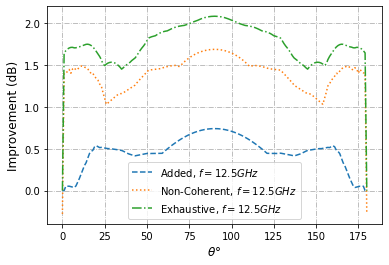

In [36]:
# %% plot improvement from coherent to added, non-coherent, and exhaustive mode 
improvement_added = 20*np.log10(array_gain_added) - 20*np.log10(array_gain_coherent)
improvement_noncoherent = 20*np.log10(array_gain_noncoherent) - 20*np.log10(array_gain_coherent)
improvement_exhaustive = 20*np.log10(array_gain_exhaustive) - 20*np.log10(array_gain_coherent)

fig, ax = plt.subplots()
ax.plot(theta, improvement_added[:, 1], label='Added, $f = 12.5 GHz$', linestyle='--')
ax.plot(theta, improvement_noncoherent[:, 1], label='Noncoherent, $f = 12.5 GHz$', linestyle=':')
ax.plot(theta, improvement_exhaustive[:, 1], label='Exhaustive, $f = 12.5 GHz$', linestyle='-.')
ax.set_xlabel(r'$\theta\degree$', fontsize=12)
ax.set_ylabel('Improvement (dB)', fontsize=12)
ax.legend(loc ='best')
ax.grid(True, linestyle='-.')

Text(0.5, 0, 'Array Factor')

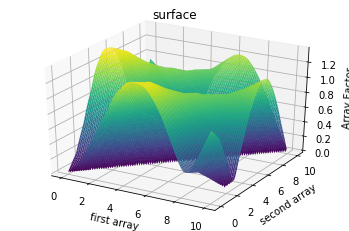

In [37]:
# %% analysis of theta = 90 for different voltages
def f(voltage_sweep_0, voltage_sweep_1, theta):
  phi_0 = (np.pi/2)*np.sin(np.pi*theta/180) * (180/np.pi)
  phi_1 = -1 * (np.pi/2)*np.sin(np.pi*theta/180) * (180/np.pi)
  IL_0 = IL_phase_for_voltage_single_theta(voltage_sweep_0, phase, amplitude, control_voltage, np.int(center_freq_new*frequency_conversion), PS_number)[0]
  phase_0 = IL_phase_for_voltage_single_theta(voltage_sweep_0, phase, amplitude, control_voltage, np.int(center_freq_new*frequency_conversion), PS_number)[1]
  IL_1 = IL_phase_for_voltage_single_theta(voltage_sweep_1, phase, amplitude, control_voltage, np.int(center_freq_new*frequency_conversion), PS_number)[0] 
  phase_1 = IL_phase_for_voltage_single_theta(voltage_sweep_1, phase, amplitude, control_voltage, np.int(center_freq_new*frequency_conversion), PS_number)[1]
  array_gain_sweep = np.abs(IL_0 * np.exp(1j*(np.pi/180)*(phase_0 - phi_0)) + IL_1 * np.exp(1j*(np.pi/180)*(phase_1 - phi_1)))
  return array_gain_sweep
voltage_sweep_0 = np.arange(0, 10.1, 0.1)
voltage_sweep_1 = np.arange(0, 10.1, 0.1)
Voltage_sweep_0, Voltage_sweep_1 = np.meshgrid(voltage_sweep_0, voltage_sweep_1)
m, n = np.shape(Voltage_sweep_0)
Z = np.zeros((m, n))
for i in range(m):
  for j in range(n):
    Z[i, j] = f(Voltage_sweep_0[i, j], Voltage_sweep_1[i, j], 90)
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot_surface(Voltage_sweep_0, Voltage_sweep_1, Z, rstride=1, cstride=1,
                cmap='viridis', edgecolor='none')
ax.set_title('surface');
ax.set_xlabel('first array')
ax.set_ylabel('second array')
ax.set_zlabel('Array Factor')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


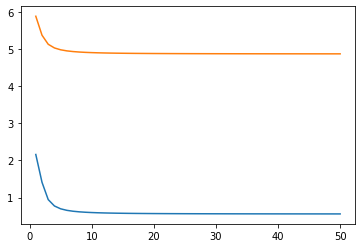

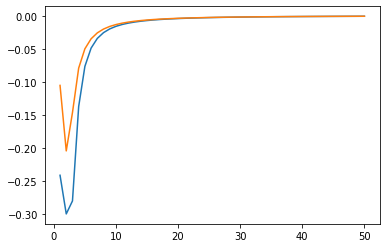

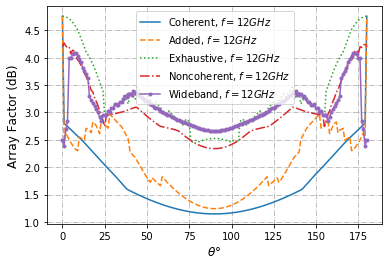

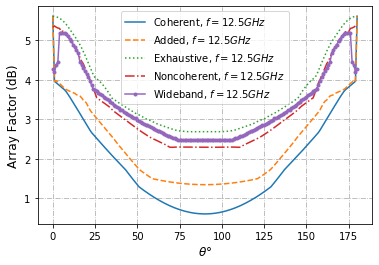

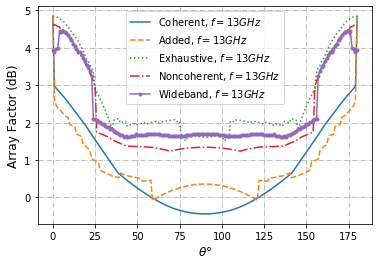

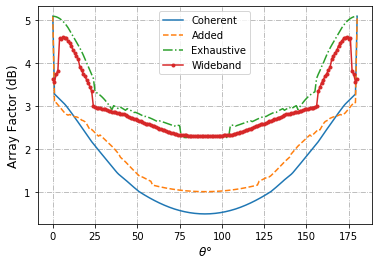

In [42]:
# %% three frequency points optimization for 1*2 array
array_number = 2

# phase parameters for initial voltage calculation (second element has a positive phase shifting)
theta = np.arange(0,181,1)
phi_1 = np.zeros((181, frequency_points))
phi_2 = np.zeros((181, frequency_points))
phi = np.zeros((181, array_number, frequency_points))
for f in range(frequency_points): 
    phi_1[:, f] = (np.pi/(2*lambda_frequency[f]))*lambda_center*np.sin(np.pi*theta/180) * (180/np.pi)
    phi_2[:, f] = (2*np.pi - (np.pi/(2*lambda_frequency[f]))*lambda_center*np.sin(np.pi*theta/180)) * (180/np.pi)
phi_2[0, :] = 0
phi_2[180, :] = 0
phi[:, 0, :] = phi_1
phi[:, 1, :] = phi_2

# gradient parameters
gradient = np.zeros((181, array_number))
gradient_rate = 10
gradient_rate_dc = 0
gradient_delta = 0.5
steps = 50
voltage_wideband = np.zeros((181, array_number))
for k in range(array_number):
  voltage_wideband[:, k] = IL_voltage_for_phase(phi[:, k, center_freq_new], phase, amplitude, control_voltage, np.int(center_freq_new*frequency_conversion), PS_number)[1]
IL_plus = np.zeros((181, array_number, frequency_points))
phase_plus = np.zeros((181, array_number, frequency_points))
IL_minus = np.zeros((181, array_number, frequency_points))
phase_minus = np.zeros((181, array_number, frequency_points))

for k in range(array_number):
  for f in range(frequency_points):
    IL_plus[:, k, f] = IL_phase_for_voltage(voltage_wideband[:, k], phase, amplitude, control_voltage, np.int(f*frequency_conversion), PS_number)[0]
    phase_plus[:, k, f] = IL_phase_for_voltage(voltage_wideband[:, k], phase, amplitude, control_voltage, np.int(f*frequency_conversion), PS_number)[1]
    IL_minus[:, k, f] = IL_phase_for_voltage(voltage_wideband[:, k], phase, amplitude, control_voltage, np.int(f*frequency_conversion), PS_number)[0]
    phase_minus[:, k, f] = IL_phase_for_voltage(voltage_wideband[:, k], phase, amplitude, control_voltage, np.int(f*frequency_conversion), PS_number)[1]

step_voltage = np.zeros((steps,array_number))
step_gradient = np.zeros((steps,array_number))

# phase parameters (second element has a minus phase shifting)
theta = np.arange(0,181,1)
phi_1 = np.zeros((181, frequency_points))
phi_2 = np.zeros((181, frequency_points))
phi = np.zeros((181, array_number, frequency_points))
for f in range(frequency_points): 
    phi_1[:, f] = (np.pi/(2*lambda_frequency[f]))*lambda_center*np.sin(np.pi*theta/180) * (180/np.pi)
    phi_2[:, f] =  -1 * (np.pi/(2*lambda_frequency[f]))*lambda_center*np.sin(np.pi*theta/180) * (180/np.pi)
phi[:, 0, :] = phi_1
phi[:, 1, :] = phi_2

result_phase = 90
for i in range(steps):    
  for k in range(array_number):        
    array_gain_singletone_plus = np.zeros((181, frequency_points), np.complex)
    array_gain_singletone_minus = np.zeros((181, frequency_points), np.complex)
    for f in range(frequency_points):
      IL_plus[:, k, f] = IL_phase_for_voltage(np.remainder(voltage_wideband[:, k]+gradient_delta, 8.3), phase, amplitude, control_voltage, np.int(f*frequency_conversion), PS_number)[0]
      phase_plus[:, k, f] = IL_phase_for_voltage(np.remainder(voltage_wideband[:, k]+gradient_delta, 8.3), phase, amplitude, control_voltage, np.int(f*frequency_conversion), PS_number)[1]
      IL_minus[:, k, f] = IL_phase_for_voltage(np.remainder(voltage_wideband[:, k]-gradient_delta, 8.3), phase, amplitude, control_voltage, np.int(f*frequency_conversion), PS_number)[0]
      phase_minus[:, k, f] = IL_phase_for_voltage(np.remainder(voltage_wideband[:, k]-gradient_delta, 8.3), phase, amplitude, control_voltage, np.int(f*frequency_conversion), PS_number)[1]

      for n in range(array_number):
        array_gain_singletone_plus[:, f] = array_gain_singletone_plus[:, f] + (IL_plus[:, n, f] * np.exp(1j*(np.pi/180)*(phase_plus[:, n, f] - phi[:, n, f])))
        array_gain_singletone_minus[:, f] = array_gain_singletone_minus[:, f] + (IL_minus[:, n, f] * np.exp(1j*(np.pi/180)*(phase_minus[:, n, f] - phi[:, n, f])))
                
    array_gain_singletone_plus = np.abs(array_gain_singletone_plus)
    array_gain_singletone_minus = np.abs(array_gain_singletone_minus)
    array_gain_singletone_plus = np.power(array_gain_singletone_plus, 2)
    array_gain_singletone_minus = np.power(array_gain_singletone_minus, 2)      
            
    array_gain_wideband_plus = np.zeros((181, 1))
    array_gain_wideband_minus = np.zeros((181, 1))
    for f in range(frequency_points):
      array_gain_wideband_plus = array_gain_wideband_plus + np.reshape(array_gain_singletone_plus[:, f], (181, 1))
      array_gain_wideband_minus = array_gain_wideband_minus + np.reshape(array_gain_singletone_minus[:, f], (181, 1))
 
    gradient[:, k] = (1/(2*gradient_delta)) * np.reshape((np.sqrt(array_gain_wideband_plus) - np.sqrt(array_gain_wideband_minus)), (181))                                         
    voltage_wideband[:, k] = np.remainder(voltage_wideband[:, k] + (0.5 * (gradient_rate_dc + gradient_rate/(i+1))) * gradient[:, k], 8.3)
  step_voltage[i, :] = voltage_wideband[result_phase, :]
  step_gradient[i, :] = gradient[result_phase, :]
 
array_gain_wideband = np.zeros((181, frequency_points))
for f in range(frequency_points):
  IL_final_0 = IL_phase_for_voltage(voltage_wideband[:, 0], phase, amplitude, control_voltage, np.int(f*frequency_conversion), PS_number)[0]
  phase_final_0 = IL_phase_for_voltage(voltage_wideband[:, 0], phase, amplitude, control_voltage, np.int(f*frequency_conversion), PS_number)[1]
  IL_final_1 = IL_phase_for_voltage(voltage_wideband[:, 1], phase, amplitude, control_voltage, np.int(f*frequency_conversion), PS_number)[0]
  phase_final_1 = IL_phase_for_voltage(voltage_wideband[:, 1], phase, amplitude, control_voltage, np.int(f*frequency_conversion), PS_number)[1]
  array_gain_wideband[:, f] = np.abs(IL_final_0 * np.exp(1j*(np.pi/180)*(phase_final_0 - phi[:, 0, f])) + IL_final_1 * np.exp(1j*(np.pi/180)*(phase_final_1 - phi[:, 1, f])))
  
plt.figure('Step Voltage')        
plt.plot(np.arange(1, steps+1), step_voltage)

plt.figure('Step Gradient')        
plt.plot(np.arange(1, steps+1), step_gradient)

fig, ax = plt.subplots()
ax.plot(theta, 20*np.log10(array_gain_coherent[:, 0]), label='Coherent, $f = 12 GHz$')
ax.plot(theta, 20*np.log10(np.abs(array_gain_added[:, 0])), label='Added, $f = 12 GHz$', linestyle='--')
ax.plot(theta, 20*np.log10(np.abs(array_gain_exhaustive[:, 0])), label='Exhaustive, $f = 12 GHz$', linestyle=':')
ax.plot(theta, 20*np.log10(np.abs(array_gain_noncoherent[:, 0])), label='Noncoherent, $f = 12 GHz$', linestyle='-.')
ax.plot(theta, 20*np.log10(np.abs(array_gain_wideband[:, 0])), label='Wideband, $f = 12 GHz$', marker=".")
ax.set_xlabel(r'$\theta\degree$', fontsize=12)
ax.set_ylabel('Array Factor (dB)', fontsize=12)
ax.legend(loc ='best')
ax.grid(True, linestyle='-.')

fig, ax = plt.subplots()
ax.plot(theta, 20*np.log10(array_gain_coherent[:, 1]), label='Coherent, $f = 12.5 GHz$')
ax.plot(theta, 20*np.log10(np.abs(array_gain_added[:, 1])), label='Added, $f = 12.5 GHz$', linestyle='--')
ax.plot(theta, 20*np.log10(np.abs(array_gain_exhaustive[:, 1])), label='Exhaustive, $f = 12.5 GHz$', linestyle=':')
ax.plot(theta, 20*np.log10(np.abs(array_gain_noncoherent[:, 1])), label='Noncoherent, $f = 12.5 GHz$', linestyle='-.')
ax.plot(theta, 20*np.log10(np.abs(array_gain_wideband[:, 1])), label='Wideband, $f = 12.5 GHz$', marker=".")
ax.set_xlabel(r'$\theta\degree$', fontsize=12)
ax.set_ylabel('Array Factor (dB)', fontsize=12)
ax.legend(loc ='best')
ax.grid(True, linestyle='-.')

fig, ax = plt.subplots()
ax.plot(theta, 20*np.log10(array_gain_coherent[:, 2]), label='Coherent, $f = 13 GHz$')
ax.plot(theta, 20*np.log10(np.abs(array_gain_added[:, 2])), label='Added, $f = 13 GHz$', linestyle='--')
ax.plot(theta, 20*np.log10(np.abs(array_gain_exhaustive[:, 2])), label='Exhaustive, $f = 13 GHz$', linestyle=':')
ax.plot(theta, 20*np.log10(np.abs(array_gain_noncoherent[:, 2])), label='Noncoherent, $f = 13 GHz$', linestyle='-.')
ax.plot(theta, 20*np.log10(np.abs(array_gain_wideband[:, 2])), label='Wideband, $f = 13 GHz$', marker=".")
ax.set_xlabel(r'$\theta\degree$', fontsize=12)
ax.set_ylabel('Array Factor (dB)', fontsize=12)
ax.legend(loc ='best')
ax.grid(True, linestyle='-.')

fig, ax = plt.subplots()
ax.plot(theta, 10*np.log10((1/3)*(np.power(array_gain_coherent[:, 0], 2)+np.power(array_gain_coherent[:, 1], 2)+np.power(array_gain_coherent[:, 2], 2))), label='Coherent')
ax.plot(theta, 10*np.log10((1/3)*(np.power(np.abs(array_gain_added[:, 0]), 2)+np.power(np.abs(array_gain_added[:, 1]), 2)+np.power(np.abs(array_gain_added[:, 2]), 2))), label='Added', linestyle='--')
ax.plot(theta, 10*np.log10((1/3)*(np.power(np.abs(array_gain_exhaustive[:, 0]), 2)+np.power(np.abs(array_gain_exhaustive[:, 1]), 2)+np.power(np.abs(array_gain_exhaustive[:, 2]), 2))), label='Exhaustive', linestyle='-.')
#ax.plot(theta, 10*np.log10((1/3)*(np.power(np.abs(array_gain_noncoherent[:, 0]), 2)+np.power(np.abs(array_gain_noncoherent[:, 1]), 2)+np.power(np.abs(array_gain_noncoherent[:, 2]), 2))), label='Non-Coherent', linestyle=':')
ax.plot(theta, 10*np.log10((1/3)*(np.power(np.abs(array_gain_wideband[:, 0]), 2)+np.power(np.abs(array_gain_wideband[:, 1]), 2)+np.power(np.abs(array_gain_wideband[:, 2]), 2))), label='Wideband', marker=".")
ax.set_xlabel(r'$\theta\degree$', fontsize=12)
ax.set_ylabel('Array Factor (dB)', fontsize=12)
ax.legend(loc ='best')
ax.grid(True, linestyle='-.')
#plt.savefig('wideband-comparison.eps')
#files.download("wideband-comparison.eps")